In [1]:
%load_ext nb_black
import os

PAPER_ROOT = os.path.expanduser(os.environ.get("PAPER_ROOT", "."))

<IPython.core.display.Javascript object>

# Comparison of XSMC and PSMC

## Setup code

In [2]:
import xsmc
import xsmc.sampler
from xsmc import Segmentation
from xsmc.supporting.plotting import *
from xsmc.supporting.kde_ne import kde_ne
import matplotlib.pyplot as plt
import numpy as np
import msprime as msp
from scipy.interpolate import PPoly
import tskit
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
import logging
import os.path

logging.getLogger("xsmc").setLevel(logging.INFO)

<IPython.core.display.Javascript object>

In [3]:
# Ensure reproducibility in posterior sampling
np.random.seed(1)


def seed():
    return np.random.randint(1, np.iinfo(np.int32).max)

<IPython.core.display.Javascript object>

The `xsmc.supporting.psmc` module runs Li & Durbin's original PSMC method on tree sequence data.

In [4]:
!pip install git+https://github.com/terhorst/mspsmc@e583e196f

  Cloning https://github.com/terhorst/mspsmc (to revision e583e196f) to /tmp/pip-req-build-z7s9zpy2
  Created wheel for mspsmc: filename=mspsmc-0.1.0-py2.py3-none-any.whl size=5757 sha256=6961418aa633d0180cec574751c509435246e3a7d5541bd1d739840903c4ee9e
  Stored in directory: /tmp/pip-ephem-wheel-cache-5a52eh0a/wheels/af/38/87/3eee2ca03eb580f4df9e22215d1e0ff5a8914f16a45cf26f93
Successfully built mspsmc
You should consider upgrading via the '/home/terhorst/opt/py37/bin/python3 -m pip install --upgrade pip' command.


<IPython.core.display.Javascript object>

In [5]:
# psmc code
import os

os.environ["PSMC_PATH"] = "/scratch/psmc/psmc"  # update as needed if running locally
import mspsmc


def run_psmc(reps, rho_over_theta=1.0):
    def f(data, *args):
        return mspsmc.msPSMC([(data, (0, 1))]).estimate(*args)

    with ThreadPoolExecutor() as p:
        futs = [p.submit(f, data, "-r", 1.0 / rho_over_theta) for data in reps]
        res = [f.result() for f in futs]
    rescaled = []
    for r in res:
        # See Appendix I of https://github.com/lh3/psmc/blob/master/README
        N0 = r.theta / (4 * mu) / 100
        rescaled.append(r.Ne.rescale(2 * N0))
    return rescaled


mspsmc.__psmc__version__

'0.6.5-r67'

<IPython.core.display.Javascript object>

In [6]:
# other supporting functions
L = int(5e7)  # length of simulated chromosome
mu = 1.4e-8  # mutation rate/bp/gen
M = 25  # number of replicates


def parallel_sample(reps, j=100, k=int(L / 50_000), rho_over_theta=1.0):
    xs = [
        xsmc.XSMC(data, focal=0, panel=[1], rho_over_theta=rho_over_theta)
        for data in reps
    ]
    with ThreadPoolExecutor() as p:
        futs = [
            p.submit(x.sample_heights, j=j, k=k, seed=seed()) for i, x in enumerate(xs)
        ]
        return np.array(
            [f.result() * 2 * x.theta / (4 * mu) for f, x in zip(futs, xs)]
        )  # rescale each sampled path by 2N0 so that segment heights are in generations


def parallel_sample0(reps, j=100, k=int(L / 50_000), rho_over_theta=1.0):
    xs = [
        xsmc.XSMC(data, focal=0, panel=[1], rho_over_theta=rho_over_theta)
        for data in reps
    ]
    with ProcessPoolExecutor() as p:
        futs = [
            p.submit(x.sample, k=j, seed=seed(), prime=True) for i, x in enumerate(xs)
        ]
        paths = [
            [p.rescale(2 * x.theta / (4 * mu)) for p in f.result()]
            for f, x in zip(futs, xs)
        ]  # rescale each sampled path by 2N0 so that segment heights are in generations
    return np.array([[p(np.random.uniform(0, L, k)) for p in path] for path in paths])


def sim_data(de, **kwargs):
    d = dict(
        sample_size=2,
        recombination_rate=1.4e-8,
        mutation_rate=mu,
        length=L,
        demographic_events=de,
    )

    d.update(kwargs)
    with ThreadPoolExecutor() as p:
        futs = [p.submit(msp.simulate, **d, random_seed=seed()) for i in range(M)]
        return [f.result() for f in futs]


def summarize_lines(xys, x0):
    "summarize a collection of lines by plotting their median and IQR"
    y0 = []
    for x, y in xys:
        f = interp1d(
            x, y, bounds_error=False
        )  # interpolate linearly to a common set of points
        y0.append(f(x0))
    return np.nanquantile(y0, [0.5, 0.25, 0.75], axis=0)  # median, q25, q75


def plot_summary(ax, lines, x, label=None, **kwargs):
    all_x = np.concatenate([l[0] for l in lines]).reshape(-1)
    m, q25, q75 = summarize_lines(lines, x)
    ax.plot(x, m / 2, label=label, **kwargs)
    ax.fill_between(x, q25 / 2, q75 / 2, **kwargs, alpha=0.5)


def plot_combined(lines_psmc, lines_xsmc, truth, ax=None):
    if ax is None:
        ax = plt.gca()
    x = np.geomspace(1e2, 1e6, 200)
    for lines, label, color in zip(
        [lines_xsmc, lines_psmc], ["XSMC", "PSMC"], ["tab:blue", "tab:red"]
    ):
        #         for i, (x, y) in enumerate(lines):
        #             ax.plot(
        #                 x,
        #                 y,
        #                 color=color,
        #                 label=label if i == 0 else None,
        #                 alpha=5.0 / len(lines),
        #             )
        plot_summary(ax, lines, x, label=label, color=color)
    ax.plot(
        *truth, "--", color="darkgrey", label="Truth", drawstyle="steps-post", zorder=0
    )
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(1e2, 1e5)
    ax.set_ylim(1e3, 1e6)

<IPython.core.display.Javascript object>

In [7]:
from collections import Counter
from scipy.signal import convolve
from xsmc.supporting.kde_ne import *


def parallel_kde(sampled_heights, **kwargs):
    with ProcessPoolExecutor() as p:
        futs = [p.submit(kde_ne, h.reshape(-1), **kwargs) for h in sampled_heights]
        return [(f.result()[0], f.result()[1]) for f in futs]

<IPython.core.display.Javascript object>

## Constant effective population size
The simplest case. First we check the estimator on "perfect" data, that is i.i.d. samples from the true distribution:

In [8]:
de = [msp.PopulationParametersChange(time=0, initial_size=1e4)]

<IPython.core.display.Javascript object>

### Perfect data

Verify the estimator on "perfect" data:

(1000.0, 100000.0)

2020-10-22 17:02:57,282 WARNING matplotlib.font_manager MainThread findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


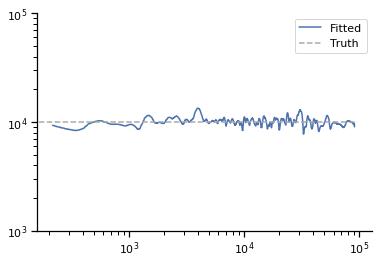

<IPython.core.display.Javascript object>

In [9]:
true_data = np.array(
    [
        next(sim.trees()).get_time(2)
        for sim in msp.simulate(
            num_replicates=10000, demographic_events=de, sample_size=2
        )
    ]
)
x, y = kde_ne(true_data)
plt.plot(x, y / 2, label="Fitted")
plt.plot(plt.xlim(), [1e4] * 2, "--", color="darkgrey", label="Truth")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.ylim(1e3, 1e5)

### XSMC 
Next we simulate data and sample from the posterior instead.

In [10]:
data = sim_data(de)
len(data)

25

<IPython.core.display.Javascript object>

In [ ]:
sampled_heights = parallel_sample(data)
sampled_heights.shape

In [ ]:
lines_xsmc = parallel_kde(sampled_heights)

In [ ]:
# Diagnostic
q = np.linspace(0, 1.0, 100)
plt.plot(np.quantile(sampled_heights.reshape(-1), q), np.quantile(true_data, q))
plt.plot(plt.xlim(), plt.xlim())

### PSMC

In [ ]:
psmc_out = run_psmc(data)

In [ ]:
x_psmc = np.geomspace(1e2, 1e5, 100)
lines_psmc = [(x_psmc, r(x_psmc)) for r in psmc_out]

### Combined plot for paper

In [ ]:
truth = ([1e2, 1e6], [1e4, 1e4])
fig, axs = plt.subplots(ncols=3, figsize=(12, 4.5), sharex=True, sharey=True, dpi=150)
plot_combined(lines_psmc, lines_xsmc, truth, axs[0])
# a.legend()
axs[0].set_xlim(1e2, 1e5)
axs[0].set_ylim(1e3, 1e6)
axs[0].set_title("Constant")
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor="none", top=False, bottom=False, left=False, right=False)
# plt.xlabel("common X")
# plt.ylabel("common Y")
plt.xlabel("Generations")
plt.ylabel("$N_e$")
plt.tight_layout(pad=1.5)

## Recent growth

### Perfect data

In [ ]:
de = [
    msp.PopulationParametersChange(time=0, initial_size=1e6),
    msp.PopulationParametersChange(time=1e3, initial_size=5e3),
    msp.PopulationParametersChange(time=2e3, initial_size=2e4),
]

In [ ]:
true_data = np.array(
    [
        next(sim.trees()).get_time(2)
        for sim in msp.simulate(
            num_replicates=10000, demographic_events=de, sample_size=2, Ne=1
        )
    ]
)

In [ ]:
x, y = kde_ne(true_data)
plt.plot(x[::50], y[::50] / 2)  # downsample the curves to make plotting faster
truth = ([0, 1e3, 2e3, 1e5], [1e6, 5e3, 2e4, 2e4])


plt.plot(
    *truth, "--", color="darkgrey", label="Truth", drawstyle="steps-post",
)
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.xlim(1e2, 1e5)

### XSMC

In [ ]:
data = sim_data(de)

In [ ]:
sampled_heights = parallel_sample(data)

In [ ]:
lines_xsmc = parallel_kde(sampled_heights)

### PSMC

In [ ]:
psmc_out = run_psmc(data)

In [ ]:
lines_psmc = [(x_psmc, r(x_psmc)) for r in psmc_out]

### Combined plot for paper

In [ ]:
plot_combined(lines_psmc, lines_xsmc, truth, axs[1])
axs[1].set_title("Growth")
fig

## Zigzag

In [ ]:
import stdpopsim

species = stdpopsim.get_species("HomSap")
model = species.get_demographic_model("Zigzag_1S14")
de = [
    msp.PopulationParametersChange(time=0, initial_size=14312)
] + model.demographic_events

### Perfect data

In [ ]:
true_data = np.array(
    [
        next(sim.trees()).get_time(2)
        for sim in msp.simulate(
            num_replicates=10000, demographic_events=de, sample_size=2,
        )
    ]
)

In [ ]:
x, y = kde_ne(true_data)
plt.plot(x[::50], y[::50] / 2)  # downsample the curves to make plotting faster

f = plot_de(de, 14312)
x_zz = np.geomspace(1e2, 1e6, 1000)
truth = (x_zz, f(x_zz))


plt.plot(
    *truth, "--", color="darkgrey", label="Truth", drawstyle="steps-post",
)
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.xlim(1e2, 1e5)

### XSMC

In [ ]:
data = sim_data(de, recombination_rate=1e-9)

In [ ]:
sampled_heights = parallel_sample(data, rho_over_theta=1e-9 / mu)

In [ ]:
lines_xsmc = parallel_kde(sampled_heights)

### PSMC

In [ ]:
psmc_out = run_psmc(data, rho_over_theta=1e-9 / mu)

In [ ]:
lines_psmc = [(x_psmc, r(x_psmc)) for r in psmc_out]

### Combined plot for paper

/home/terhorst/opt/py37/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1392: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


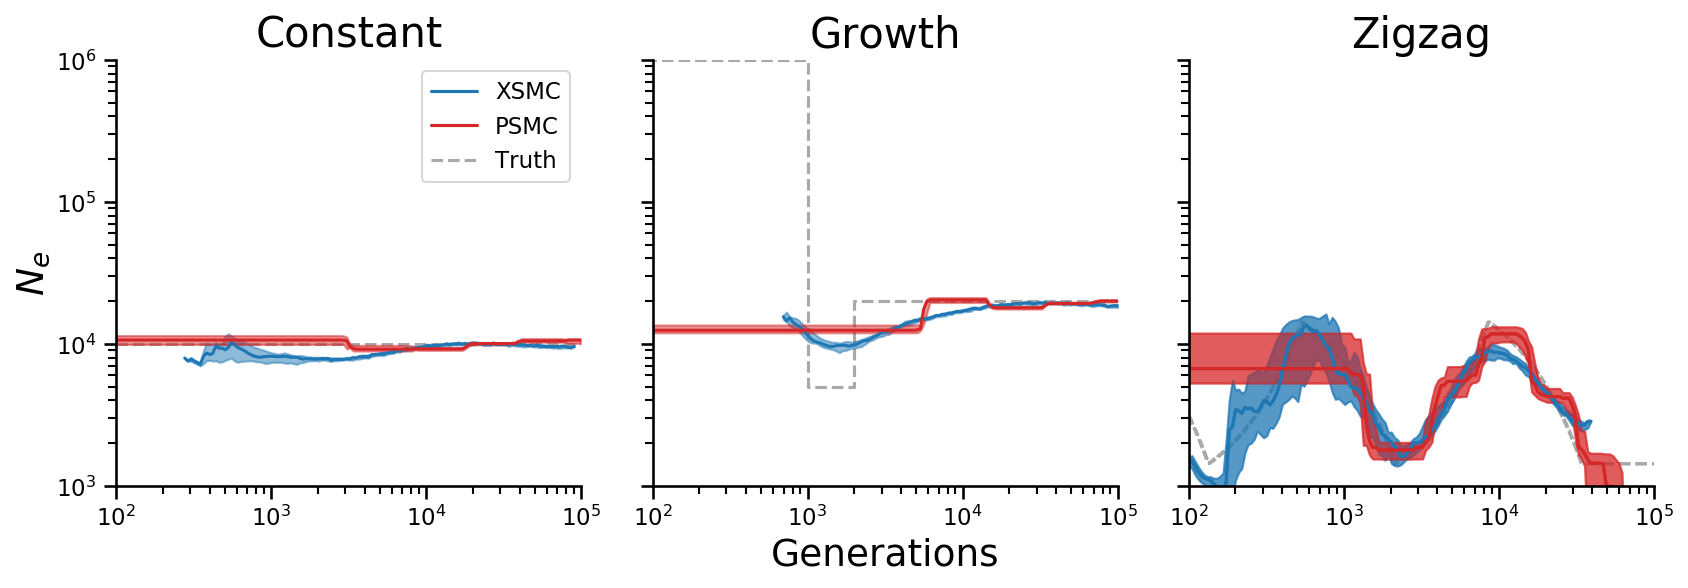

<IPython.core.display.Javascript object>

In [38]:
plot_combined(lines_psmc, lines_xsmc, truth, axs[2])
axs[2].set_title("Zigzag")
fig

In [42]:
axs[0].legend()

<IPython.core.display.Javascript object>

In [40]:
fig.savefig(os.path.join(PAPER_ROOT, "figures", "xsmc_psmc.pdf"))

<IPython.core.display.Javascript object>

## Additional diagnostics

In [ ]:
b = np.linspace(4, 12, 32)
for d in np.array(sampled_heights)[..., 0], true_data:
    plt.hist(np.log(d).reshape(-1), bins=b, density=True, alpha=0.5)